In [1]:
# !pip install torch
# !pip install matplotlib
# !pip install scikit-learn
!pip install datasets
# !pip install transformers
# !pip install 'accelerate>=0.26.0'
# !pip install transformers[torch]
# !pip uninstall nvidia-cublas-cu11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, TrainingArguments, DataCollatorWithPadding

In [3]:
# torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.9"

In [4]:
device = torch.device('cuda')
# torch.cuda.is_available()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ds_arg = pd.read_csv('/content/drive/MyDrive/Fall 2024/PUBH 8885 - Computational Biology/Project/Data/short_reads_with_type.csv')
ds_arg.head()

,id,type,Sequence
0,B9J113,beta_lactam,GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...
1,B9J113,beta_lactam,AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...
2,B9J113,beta_lactam,AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...
3,B9J113,beta_lactam,GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...
4,B9J113,beta_lactam,GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...


In [7]:
# number of unique drug resistance type
print("# Unique Resistance Types:", len(set(ds_arg['type'])),"\n\nUnique Resistance Types:", ds_arg['type'].unique())

# Unique Resistance Types: 15 

Unique Resistance Types: ['beta_lactam' 'bacitracin' 'chloramphenicol' 'aminoglycoside'
 'macrolide-lincosamide-streptogramin' 'multidrug' 'polymyxin'
 'fosfomycin' 'sulfonamide' 'glycopeptide' 'mupirocin' 'trimethoprim'
 'quinolone' 'fosmidomycin' 'tetracycline']


In [19]:
max_length = ds_arg['Sequence'].str.len().max()
max_length

100

In [8]:
ds_arg.columns

Index(['id', 'type', 'Sequence'], dtype='object')

In [9]:
# Create label encoder for drug resistance types
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(ds_arg['type'])

In [10]:
labels

array([3, 2, 2, ..., 3, 3, 3])

In [10]:
# Split data
sequences = ds_arg['Sequence'].values

# Get class counts
class_counts = np.bincount(labels)

# Find classes with only one sample
single_sample_classes = np.where(class_counts == 1)[0]

In [11]:
#If there are classes with only one sample remove them from the dataset
if len(single_sample_classes) > 0:
  print(f"Removing classes with only one sample: {single_sample_classes}")
  # Create a mask to select samples not belonging to single-sample classes
  mask = ~np.isin(labels, single_sample_classes)
  sequences = sequences[mask]
  labels = labels[mask]

In [12]:
dataset = pd.DataFrame({
    'sequence': sequences,
    'label': labels
})
print(dataset)

                                                sequence  label
0      GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...      2
1      AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...      2
2      AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...      2
3      GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...      2
4      GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...      2
...                                                  ...    ...
96140  GTGGCTGAACTCCATTACTGTCAGGGTGAAAGAAGGATTTGACAGC...      7
96141  GATTTCTTTACCTGGAACATGGACGGCGTCTTGAAAACCGTTGAAA...      7
96142  TGGTGGGCGGTATTGGTGTAATGAATATTATGCTGGTGTCAGTGAC...      7
96143  TGTTTTGCAACAGTTCCTGATCGAAGCCGTGCTGGTTTGCCTGGTC...      7
96144  TTCTTACCCGGCTGGGAGATTGGTTTTTCACCGTTGGCGCTGCTGC...      7

[96145 rows x 2 columns]


In [17]:
# Create Train Test split
train_sequences, test_sequences, train_labels, test_labels = train_test_split(dataset['sequence'], dataset['label'], test_size=0.1, random_state=42)

train_sequences, validation_sequences, train_labels, validation_labels = train_test_split(train_sequences, train_labels, test_size=0.1, random_state=42)

print("Train Size:",len(train_sequences), "\nValidation Size:", len(validation_sequences), "\nTest Size:", len(test_sequences))

Train Size: 77877 
Validation Size: 8653 
Test Size: 9615


In [14]:
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-100m-multi-species")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

In [18]:
ds_train = Dataset.from_dict({"sequence": train_sequences,'labels':train_labels})
ds_validation = Dataset.from_dict({"sequence": validation_sequences,'labels':validation_labels})
ds_test = Dataset.from_dict({"sequence": test_sequences,'labels':test_labels})

In [20]:
# Tokenize the dataset
def tokenize_function(data):
    return tokenizer(
        data['sequence'],
        padding='max_length',
        max_length=100,
        truncation=True,       # Truncate if longer than max_length
        return_tensors='pt'    # Return pytorch tensors
    )

In [21]:
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)
tokenized_datasets_validation = ds_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)
tokenized_datasets_test = ds_test.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)

Map:   0%|          | 0/77877 [00:00<?, ? examples/s]

Map:   0%|          | 0/8653 [00:00<?, ? examples/s]

Map:   0%|          | 0/9615 [00:00<?, ? examples/s]

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species",
    num_labels=len(set(ds_arg['type'])),
    trust_remote_code=True
)

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species and are newly initialized: ['classifier.dense.bias', 

In [35]:
batch_size = 8
training_Args = TrainingArguments(
    "nuc_arg_short_read",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=3.5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 4,
    per_device_eval_batch_size= 8,
    num_train_epochs= 5,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="eval_weighted_f1_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 1466
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
# Define the metric for the evaluation using the f1 score
def compute_metrics_f1_score(eval_pred):
    """Computes F1 score for multi-class classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids

    # Compute weighted F1 score to account for class imbalance
    f1 = f1_score(references, predictions, average='weighted')

    # Optionally, you can also compute micro and macro F1 scores
    macro_f1 = f1_score(references, predictions, average='macro')
    micro_f1 = f1_score(references, predictions, average='micro')

    return {
        'weighted_f1_score': f1,
        'macro_f1_score': macro_f1,
        'micro_f1_score': micro_f1
    }

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [36]:
trainer = Trainer(
    model.to(device),
    training_Args,
    data_collator=data_collator,
    train_dataset = tokenized_datasets_train,
    eval_dataset = tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_f1_score,
)

<ipython-input-36-0c1368557434>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
max_steps is given, it will override any value given in num_train_epochs


In [37]:
train_results = trainer.train()
#0ee50b9af42a643d0775410d9fce2677e382baf2

Step,Training Loss,Validation Loss,Weighted F1 Score,Macro F1 Score,Micro F1 Score
100,1.082000,1.110231,0.635148,0.231016,0.649861
200,0.958300,1.009774,0.686737,0.265863,0.699699
300,0.861700,0.999220,0.694069,0.277556,0.702475
400,0.827400,0.939802,0.714606,0.287378,0.725254
500,0.853100,0.893270,0.727981,0.295487,0.741327
600,0.909300,0.881817,0.731702,0.300565,0.747225
700,0.824800,0.853489,0.745847,0.326420,0.756129
800,0.856400,0.801979,0.762808,0.334787,0.773821
900,0.807500,0.774535,0.776282,0.353493,0.787003
1000,0.766500,0.757308,0.783439,0.348645,0.792206


In [38]:
import shutil
import os
from pathlib import Path

colab_directory_path = '/content/nuc_arg_short_read'

drive_destination_dir = '/content/drive/My Drive/'


zip_archive_path = Path(drive_destination_dir) / f"{Path(colab_directory_path).name}.zip"
shutil.make_archive(str(zip_archive_path.parent / zip_archive_path.stem), 'zip', str(colab_directory_path))

'/content/drive/My Drive/nuc_arg_short_read.zip'

In [41]:
# print(f"F1 score on the test dataset: {trainer.predict(tokenized_datasets_test).metrics['test_f1_score']}")

KeyError: 'test_f1_score'

In [42]:
print(trainer.state.log_history)

[{'loss': 1.082, 'grad_norm': 31.502859115600586, 'learning_rate': 3.2612551159618005e-05, 'epoch': 0.04109307581672488, 'step': 100}, {'eval_loss': 1.110230803489685, 'eval_weighted_f1_score': 0.635148001778528, 'eval_macro_f1_score': 0.231015523052847, 'eval_micro_f1_score': 0.6498612395929695, 'eval_runtime': 65.9015, 'eval_samples_per_second': 131.302, 'eval_steps_per_second': 16.418, 'epoch': 0.04109307581672488, 'step': 100}, {'loss': 0.9583, 'grad_norm': 20.506277084350586, 'learning_rate': 3.0225102319236013e-05, 'epoch': 0.08218615163344976, 'step': 200}, {'eval_loss': 1.0097736120224, 'eval_weighted_f1_score': 0.6867369276159828, 'eval_macro_f1_score': 0.2658630277675259, 'eval_micro_f1_score': 0.6996993524514339, 'eval_runtime': 65.8265, 'eval_samples_per_second': 131.452, 'eval_steps_per_second': 16.437, 'epoch': 0.08218615163344976, 'step': 200}, {'loss': 0.8617, 'grad_norm': 38.54680252075195, 'learning_rate': 2.7837653478854025e-05, 'epoch': 0.12327922745017464, 'step': 

In [43]:
curve_evaluation_f1_score = [
    [a['step'], a['eval_weighted_f1_score']]
    for a in trainer.state.log_history
    if 'eval_weighted_f1_score' in a.keys()
]

In [44]:
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

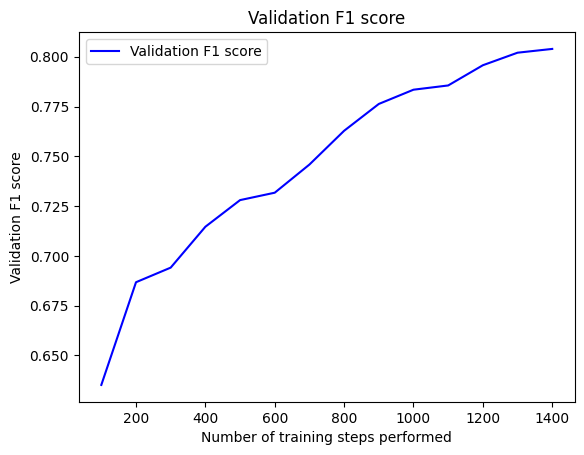

In [46]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()
plt.show()

In [47]:
test_results = trainer.predict(tokenized_datasets_test)

In [48]:
print("Test Metrics:", test_results.metrics)

Test Metrics: {'test_loss': 0.7432904839515686, 'test_weighted_f1_score': 0.7865574447956013, 'test_macro_f1_score': 0.34124270668450757, 'test_micro_f1_score': 0.7952747710241466, 'test_runtime': 73.7788, 'test_samples_per_second': 130.322, 'test_steps_per_second': 16.292}


In [49]:
predicted_classes = np.argmax(test_results.predictions, axis=1)

In [50]:
# Optionally, compare predictions with true labels
true_labels = test_results.label_ids
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.72      0.49      0.58       373
           1       0.89      0.87      0.88      3199
           2       0.83      0.84      0.83      3106
           3       0.36      0.56      0.44       218
           4       0.79      0.10      0.18       111
           6       0.00      0.00      0.00        10
           7       0.68      0.79      0.73      1309
           8       1.00      0.01      0.01       162
           9       0.00      0.00      0.00         7
          10       0.75      0.82      0.78      1107
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1

    accuracy                           0.80      9608
   macro avg       0.46      0.34      0.34      9608
weighted avg       0.80      0.80      0.79      9608



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
